# imports

In [3]:
import sys
import os
import h5py
import mattplotlib

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
import pickle
from copy import deepcopy

# plotting
import seaborn as sns
import seaborn_image as isns
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils
Running on Computer: [beast]
Save_dir = ./Monocular/


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


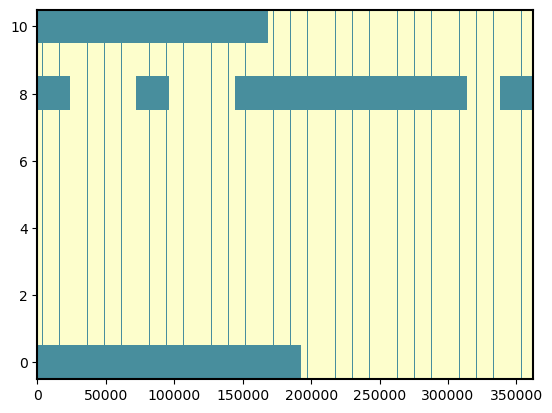

In [4]:
# load data
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

# NIM model

In [277]:
# jump right to shared models
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

In [286]:
## Shared NIM
XTreg0 = 0.1
L1reg0 = 0.0001
Greg = 0.001

# subunit layer
sub0_par = NDNLayer.layer_dict(
    input_dims=data.stim_dims, num_filters=8, norm_type=1,
    NLtype='relu', bias=False, initialize_center = True)
sub0_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'localx':0.001, 'bcs':{'d2xt':1}  }

sub1_par = NDNLayer.layer_dict(
    input_dims=None, num_filters=8, norm_type=1,
    NLtype='relu', bias=False, initialize_center = True)
sub1_par['reg_vals'] = {'l1':L1reg0, 'localx':0.001, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC,
    norm_type=0,
    NLtype='softplus',
    bias=True,
    initialize_center = True)

nim = NDN.NDN( layer_list=[sub0_par, sub1_par, readout_par] )
#nim = NDN.NDN( layer_list=[sub0_par, readout_par] )

m.lightmode()
#m.draw_model(nim)


nim.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([360, 8])
  Layer 1:
      weight: torch.Size([8, 8])
  Layer 2:
      weight: torch.Size([8, 11])
      bias: torch.Size([11])


In [6]:
#nim.fit(data, **adam_pars, verbose=2)
#LLs1 = nim.eval_models(data[data.val_inds], null_adjusted=True)
#print(LLs1)
#print(np.mean(LLs1))
# 

#with open('nim2.pickle', 'wb') as f:
#   pickle.dump(nim, f)
with open('nim_2layer.pickle', 'rb') as f:
    nim = pickle.load(f)

# NIM filters

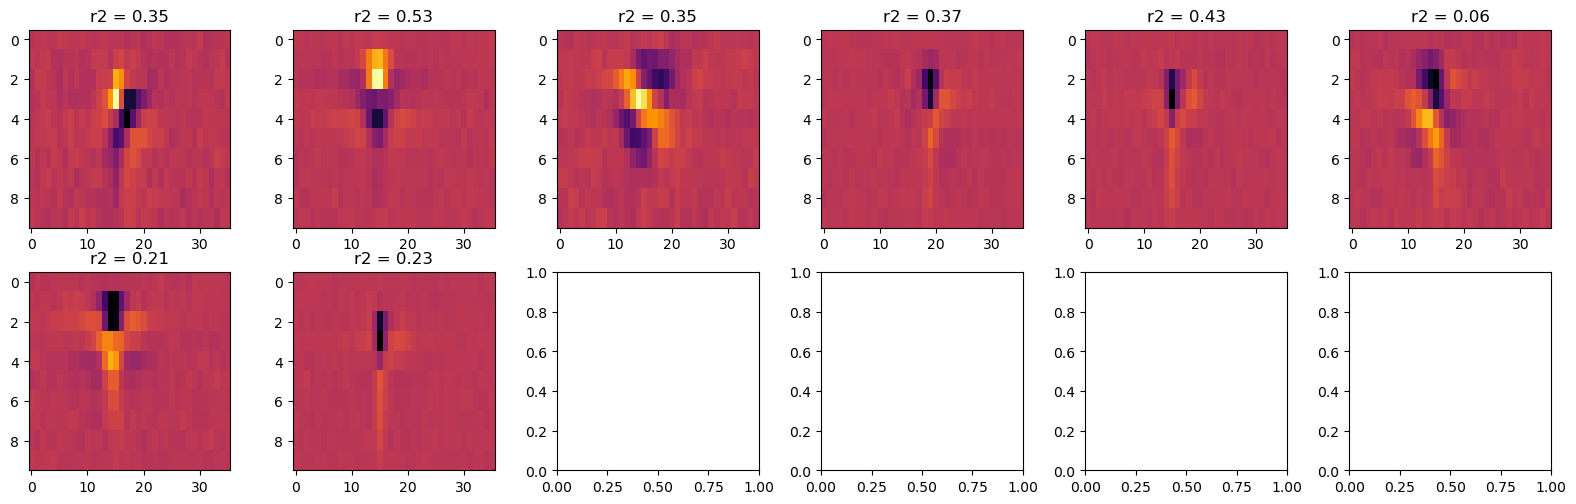

In [288]:
glm_r2s = ['%.2f'%r2 for r2 in met.r2(data, nim)]

# plot GLM filters
ss(2, 6)
for c in range(8):
    plt.subplot(2, 6, c+1)
    imagesc(nim.networks[0].layers[0].get_weights()[:,:,c], cmap='inferno')
    plt.title('r2 = ' + glm_r2s[c])
plt.show()

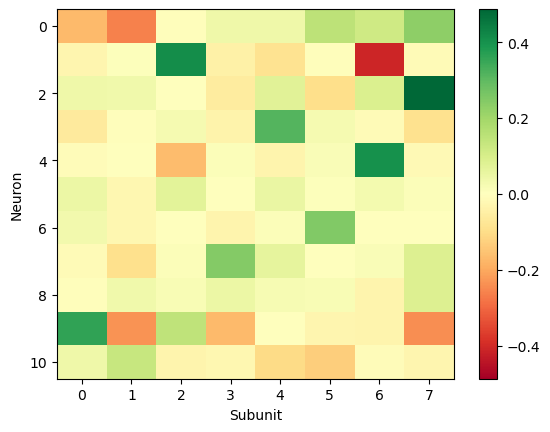

In [289]:
# Readout layer
wR = nim_all.get_weights(layer_target=1)
imagesc(wR, cmap='RdYlGn')
plt.xlabel('Subunit')
plt.ylabel('Neuron')
plt.colorbar()
plt.show()

In [475]:
3 // 8

0

# visualize receptive fields

In [365]:
# get the layers
layers = []
for l in range(len(nim.networks[0].layers)):
    layer = nim.networks[0].layers[l].get_weights()
    layers.append(layer)
    print(layer.shape)

(36, 10, 8)
(8, 8)
(8, 11)


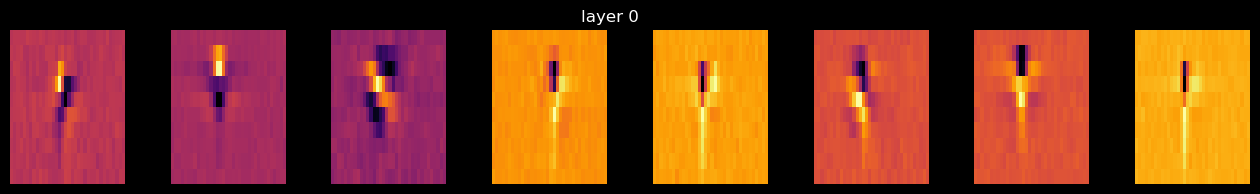

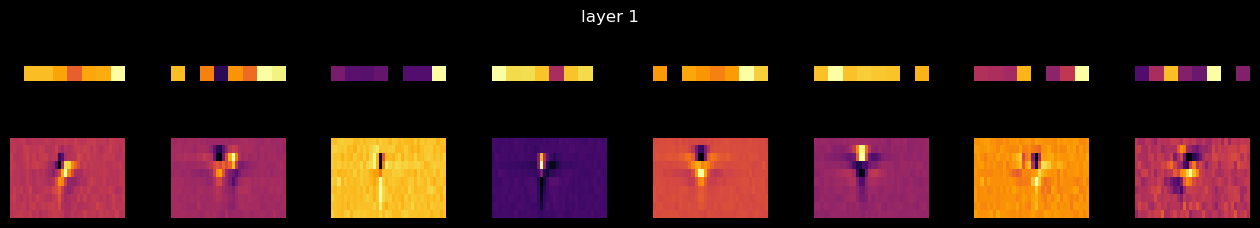

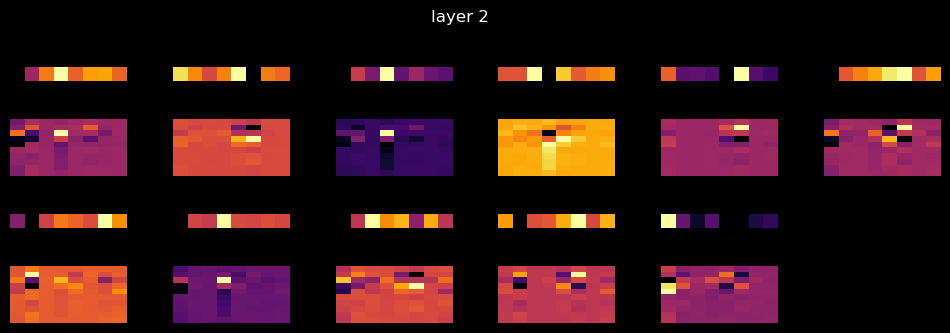

In [381]:
reload(m)
m.darkmode()
m.plot_layersNIM(layers, shapes=[(1,8), (1,8), (2,6)])

# TODO: add the top weighted elements of the previous layer displayed below the second layer (vertically)

# run the data through the network

In [331]:
y_pred = (nim({'stim': data.stim[data.val_inds]})  * data.dfs[data.val_inds]).detach().numpy()

# see the robs
nim({'stim': data.stim[data.val_inds]})

tensor([[0.0959, 2.0510, 0.0067,  ..., 0.2223, 0.5776, 0.0421],
        [0.1257, 0.1686, 0.0096,  ..., 0.1140, 0.9936, 0.0495],
        [0.1539, 0.0310, 0.0268,  ..., 0.0799, 0.1606, 0.0889],
        ...,
        [0.0737, 0.3979, 0.0129,  ..., 0.0396, 0.1188, 0.1761],
        [0.0737, 0.4981, 0.0168,  ..., 0.0460, 0.0694, 0.1632],
        [0.0609, 0.8931, 0.0224,  ..., 0.0476, 0.0629, 0.1469]],
       grad_fn=<SoftplusBackward0>)

In [392]:
# gets the position in a grid
def get_pos(shape, row, col, row_step=1):
    assert len(shape) == 2, "shape must have (num_rows, num_cols)"
    # divide row / row_step to get the actual number of rows
    # since each row has row_step # of things stacked in it
    actual_rows = row//row_step
    return actual_rows*num_cols + col

In [349]:
data.stim[0].shape, data.stim[data.val_inds].shape

(torch.Size([360]), torch.Size([68780, 360]))

In [429]:
# see layer 1
z = nim.networks[0].layers[0](data.stim[data.val_inds])
z = torch.tensor([z_i.detach().numpy() for z_i in z])
#print(z.shape)

input = data.stim[0].unsqueeze(0) # unsqueeze to make it a 2D 1xN matrix to run it through the model
prev_output = input
outputs = []
for l in range(len(nim.networks[0].layers)):
    z = nim.networks[0].layers[l](prev_output)
    # TODO: not entirely sure if I need to detach twice
    z_cpu = torch.tensor([z_i.detach().numpy() for z_i in z])
    outputs.append(z_cpu.numpy())
    print(prev_output.shape, '-->', z_cpu.shape)
    prev_output = z_cpu
    
# resize input
input = input.numpy().reshape((10, 36))

torch.Size([1, 360]) --> torch.Size([1, 8])
torch.Size([1, 8]) --> torch.Size([1, 8])
torch.Size([1, 8]) --> torch.Size([1, 11])


In [461]:
input.shape, [layer.shape for layer in layers], [output.shape for output in outputs]
#import matplotlib
#matplotlib.__version__

((10, 36), [(36, 10, 8), (8, 8), (8, 11)], [(1, 8), (1, 8), (1, 11)])

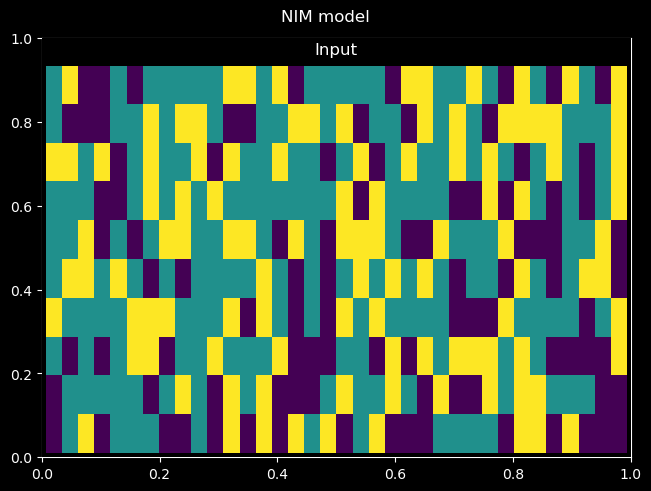

In [446]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
fig.suptitle('NIM model')

subplotspec = ax.get_subplotspec()

# plot the input
subfig = fig.add_subfigure(subplotspec)
subfig.suptitle('Input')
input_ax = subfig.add_subplot()
# to index the last axis for arrays with any number of axes
imin = np.min(input.flatten())
imax = np.max(input.flatten())
input_ax.set_axis_off() # remove axis
input_ax.imshow(input, vmin=imin, vmax=imax, aspect='auto', cmap='viridis')

torch.Size([1, 360]) --> torch.Size([1, 8])
torch.Size([1, 8]) --> torch.Size([1, 8])
torch.Size([1, 8]) --> torch.Size([1, 11])


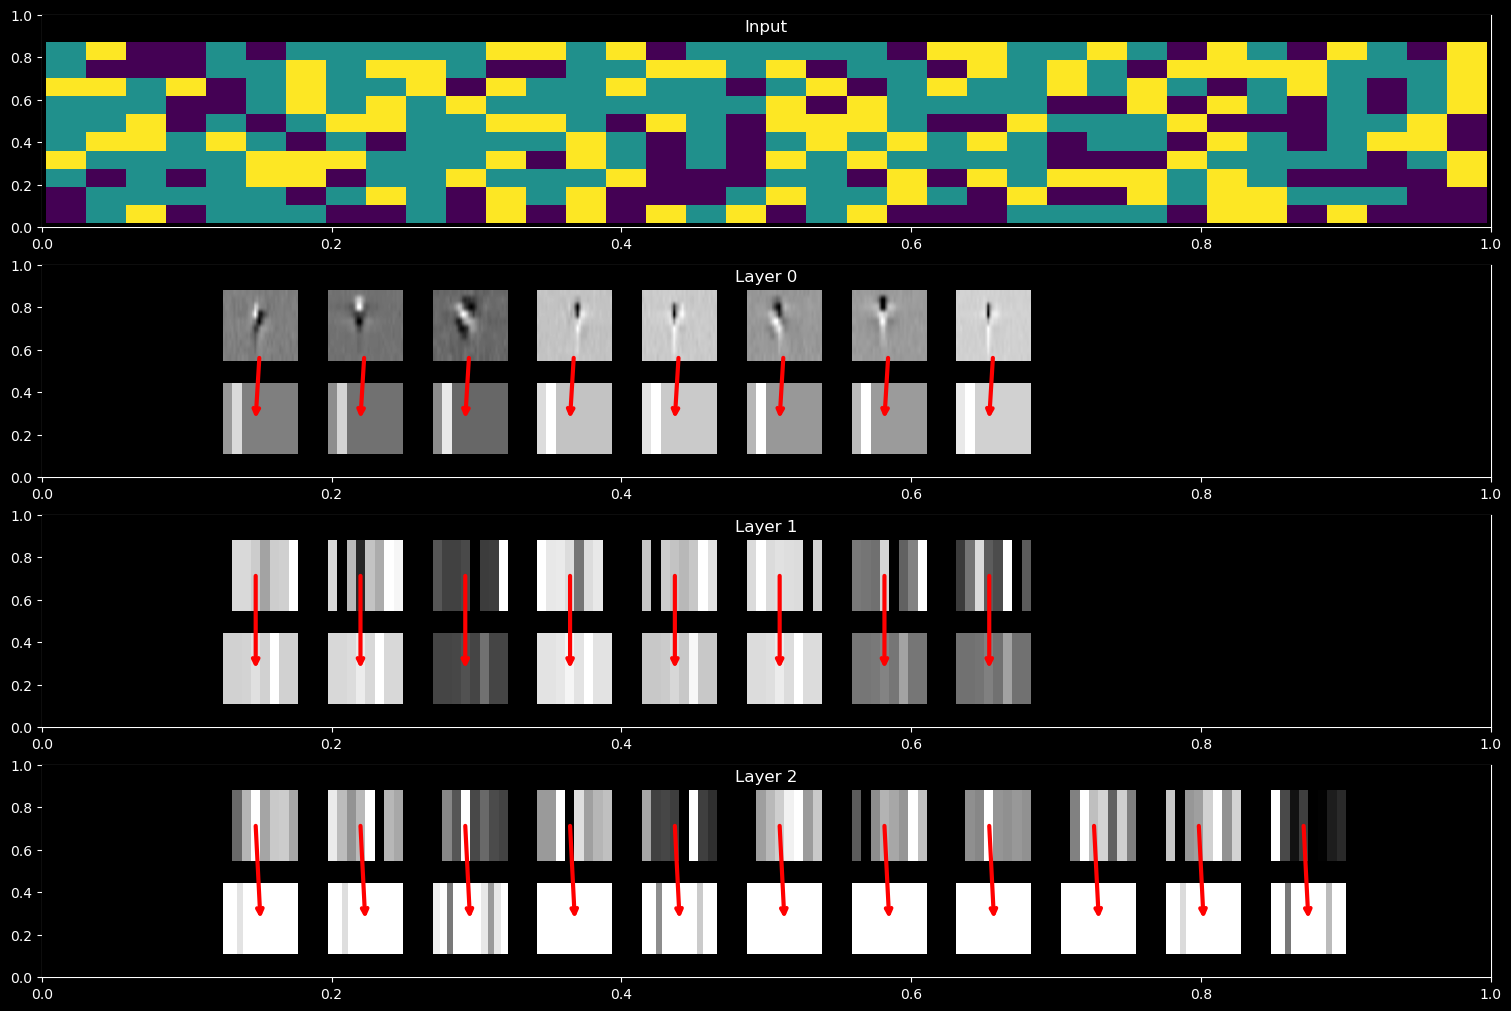

In [501]:
with open('nim_1layer.pickle', 'rb') as f:
    nim1 = pickle.load(f)
with open('nim_2layer.pickle', 'rb') as f:
    nim2 = pickle.load(f)

fig = m.simulate_network(data.stim[0].unsqueeze(0), nim2, 
                         figsize=(15,10), max_cols=11)

In [521]:
fig = m.simulate_network(data.stim[0], nim2,
                         figsize=(15,10), max_cols=11)

TypeError: simulate_network() missing 1 required positional argument: 'model'

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [12]:
input = data.stim[:1000]

verbose = True
# get the outputs
prev_output = input
outputs = []
for n in range(len(nim.networks)):
    # TODO: for scaffold networks,
    #       if the previous network is defined as a scaffold,
    #       then, concatenate all previous outputs together before calling forward
    # TODO: for parallel networks,
    #       come up with a way to visualize these parallel networks on the same row
    for l in range(len(nim.networks[n].layers)):
        z = nim.networks[n].layers[l](prev_output)
        # TODO: not entirely sure if I need to detach twice
        z_cpu = torch.tensor(np.array([z_i.detach().numpy() for z_i in z]))
        outputs.append(z_cpu.numpy())
        if verbose:
            print(prev_output.shape, '-->', z_cpu.shape)
        prev_output = z_cpu

outputs[0].shape

torch.Size([1000, 360]) --> torch.Size([1000, 8])
torch.Size([1000, 8]) --> torch.Size([1000, 8])
torch.Size([1000, 8]) --> torch.Size([1000, 11])


(1000, 8)

In [ ]:
import tqdm
m.darkmode()

num = 1000

# generate the frames
for i, input in enumerate(tqdm.tqdm(data.stim[:num])):
    fig = m.simulate_network(input, data.stim_dims,
                             nim2,
                             figsize=(25,15), max_cols=11)
    with open('figs/'+str(i)+'.png', 'wb') as f:
        fig.savefig(f)
    plt.close(fig) # to avoid displaying it every time

# write it out to an image
import os
# -r = N images / per M seconds
os.system("ffmpeg -f image2 -r 5/1 -i ./figs/%d.png -vcodec mpeg4 -y output.mp4")

  1%|▌                                                     | 51/5000 [02:14<3:27:11,  2.51s/it]

In [1]:
import os
# -r = N images / per M seconds
os.system("ffmpeg -f image2 -r 10/1 -i ./figs/%d.png -vcodec mpeg4 -y output.mp4")

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0

100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


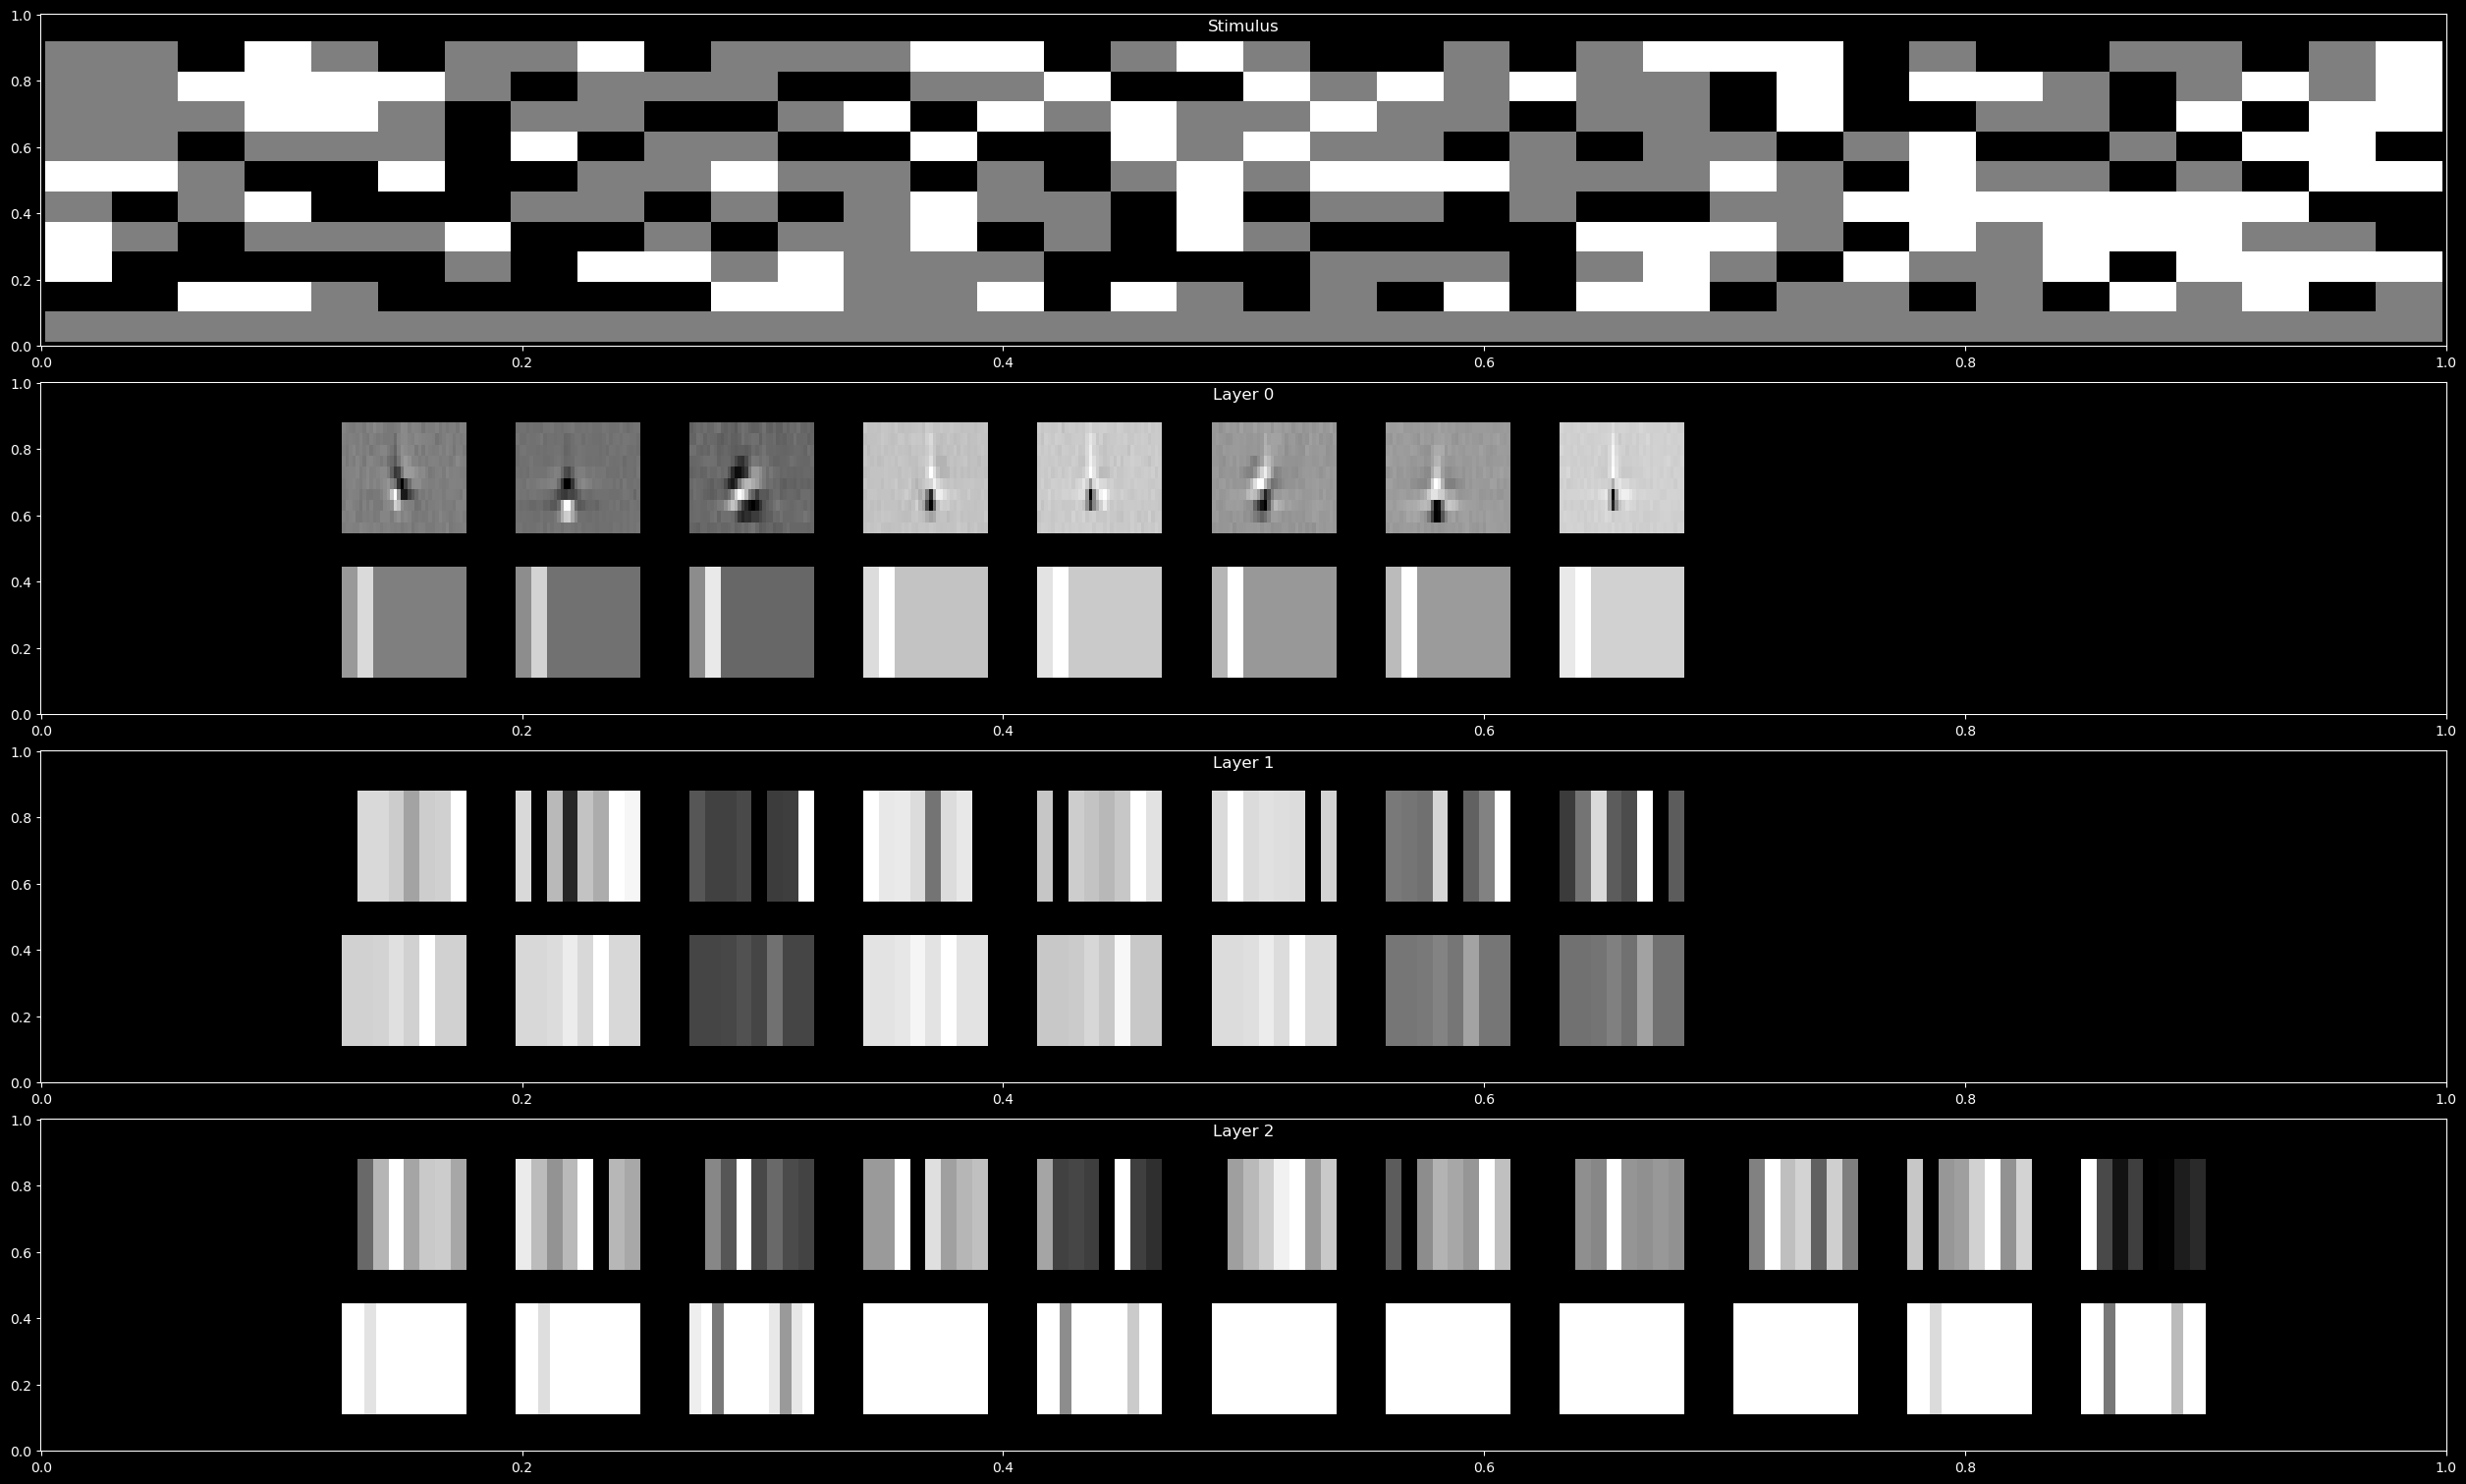

In [46]:
reload(m)
m.darkmode()
figs = m.simulate_network(data.stim[0], data.stim_dims,
                                nim,
                                figsize=(25,15), max_cols=11)

# simulate

In [60]:
reload(m)
m.darkmode()

figs = m.simulate_network_batch(data.stim[:10], data.stim_dims, 
                                nim,
                                savefig_loc='nim/nim_2layer',
                                figsize=(25,15), max_cols=11)

100%|██████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.35s/it]
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex -

In [58]:
os.path.basename('nims/nims2/model1')

'model1'

In [42]:
figs[0].show()

100%|████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


<Figure size 640x480 with 0 Axes>

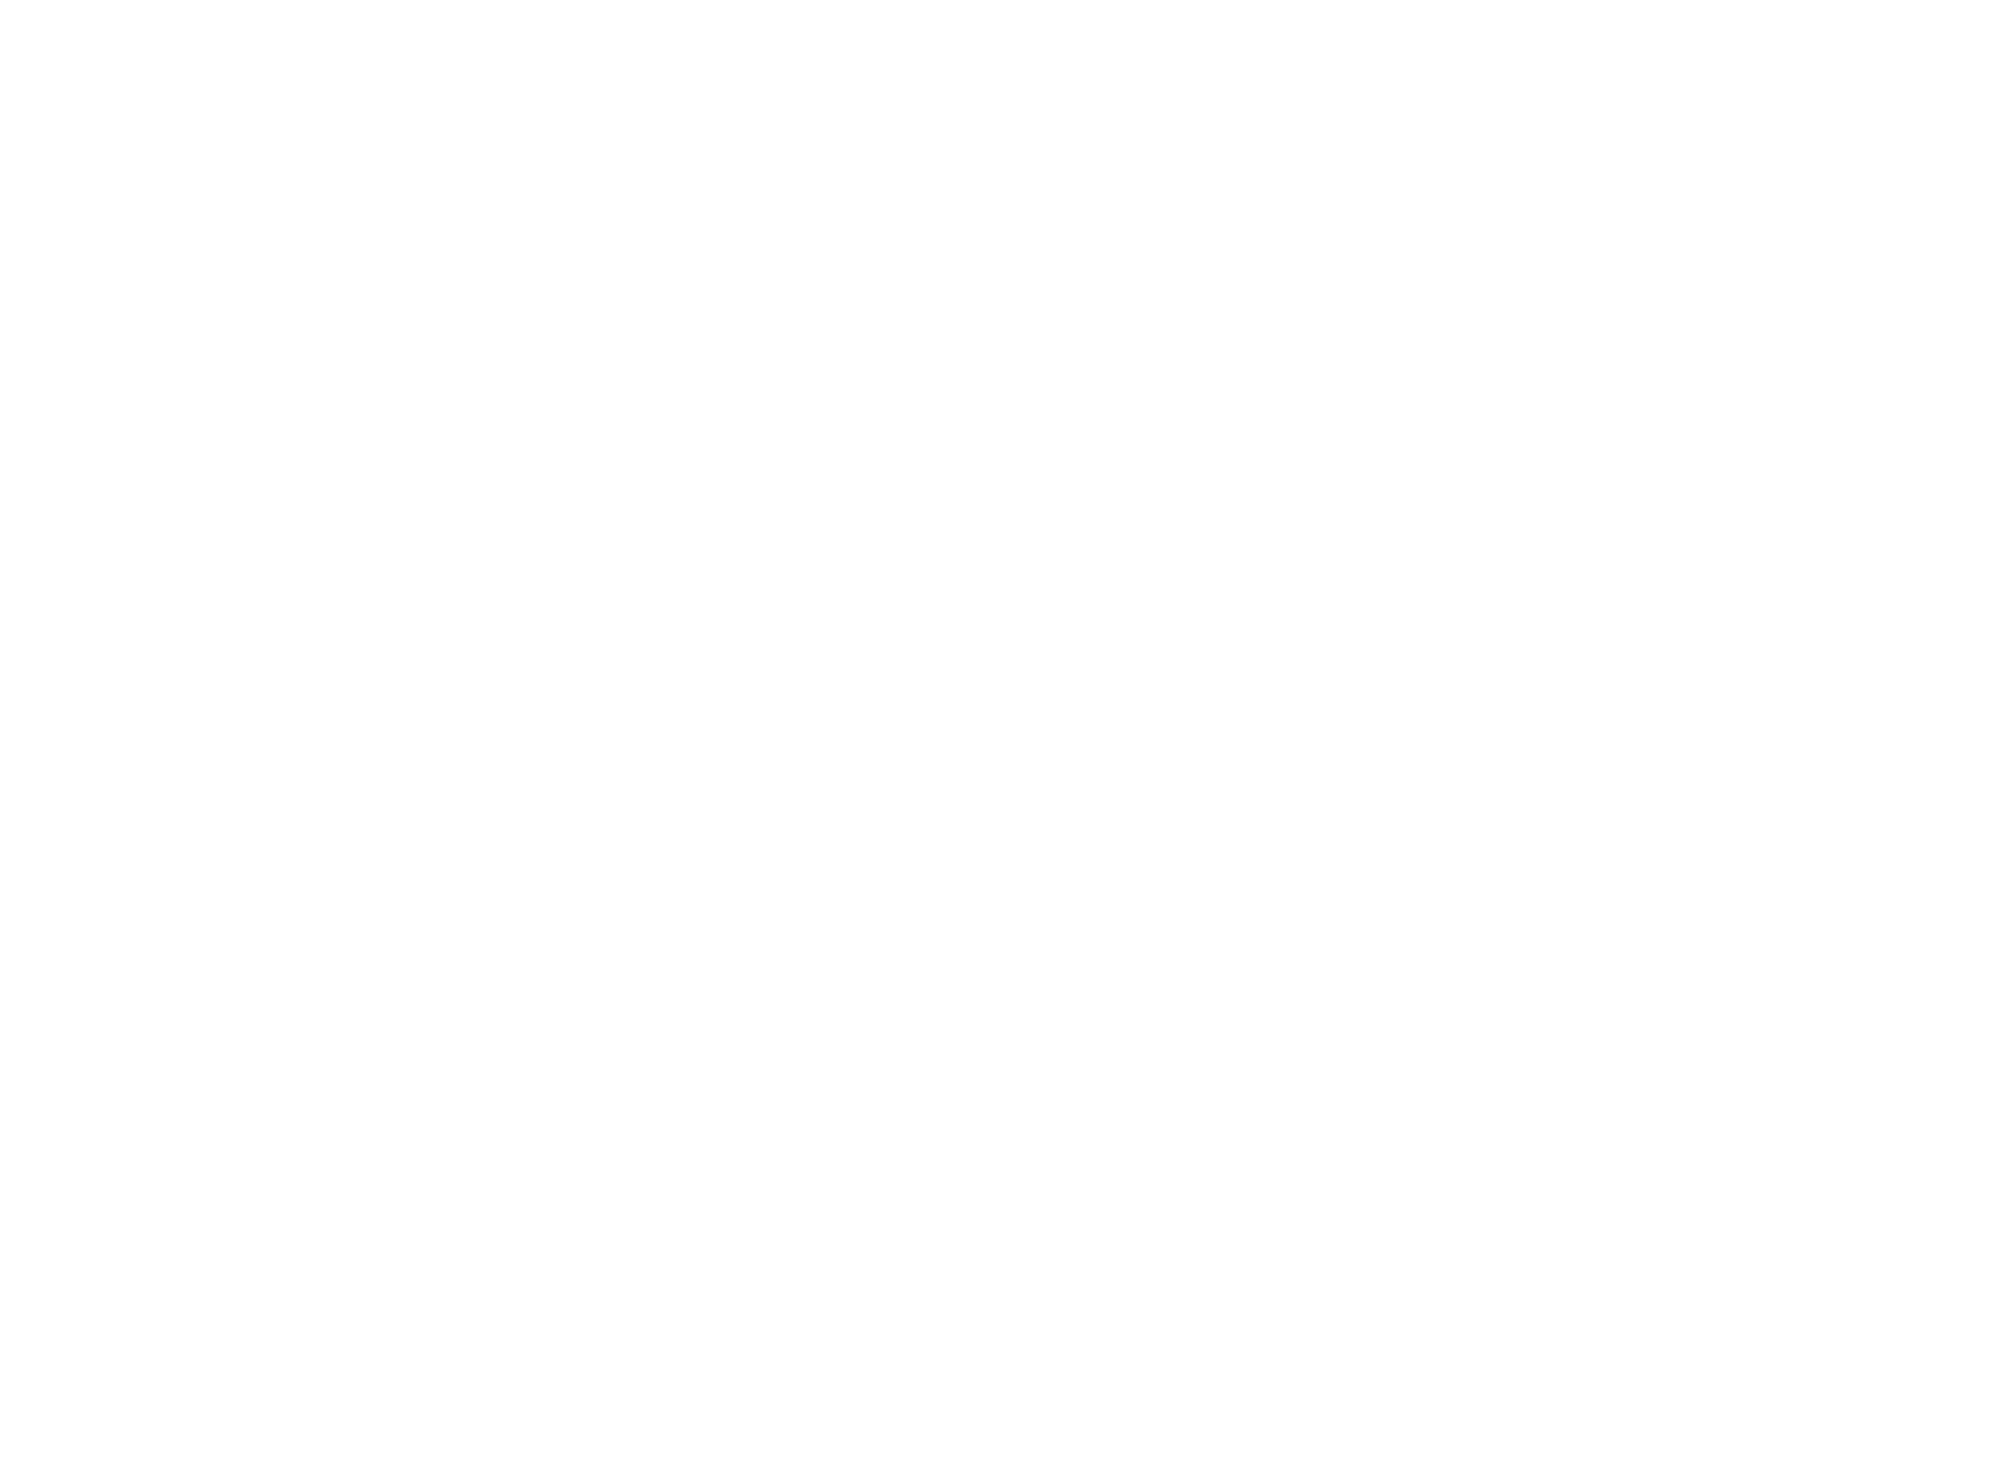

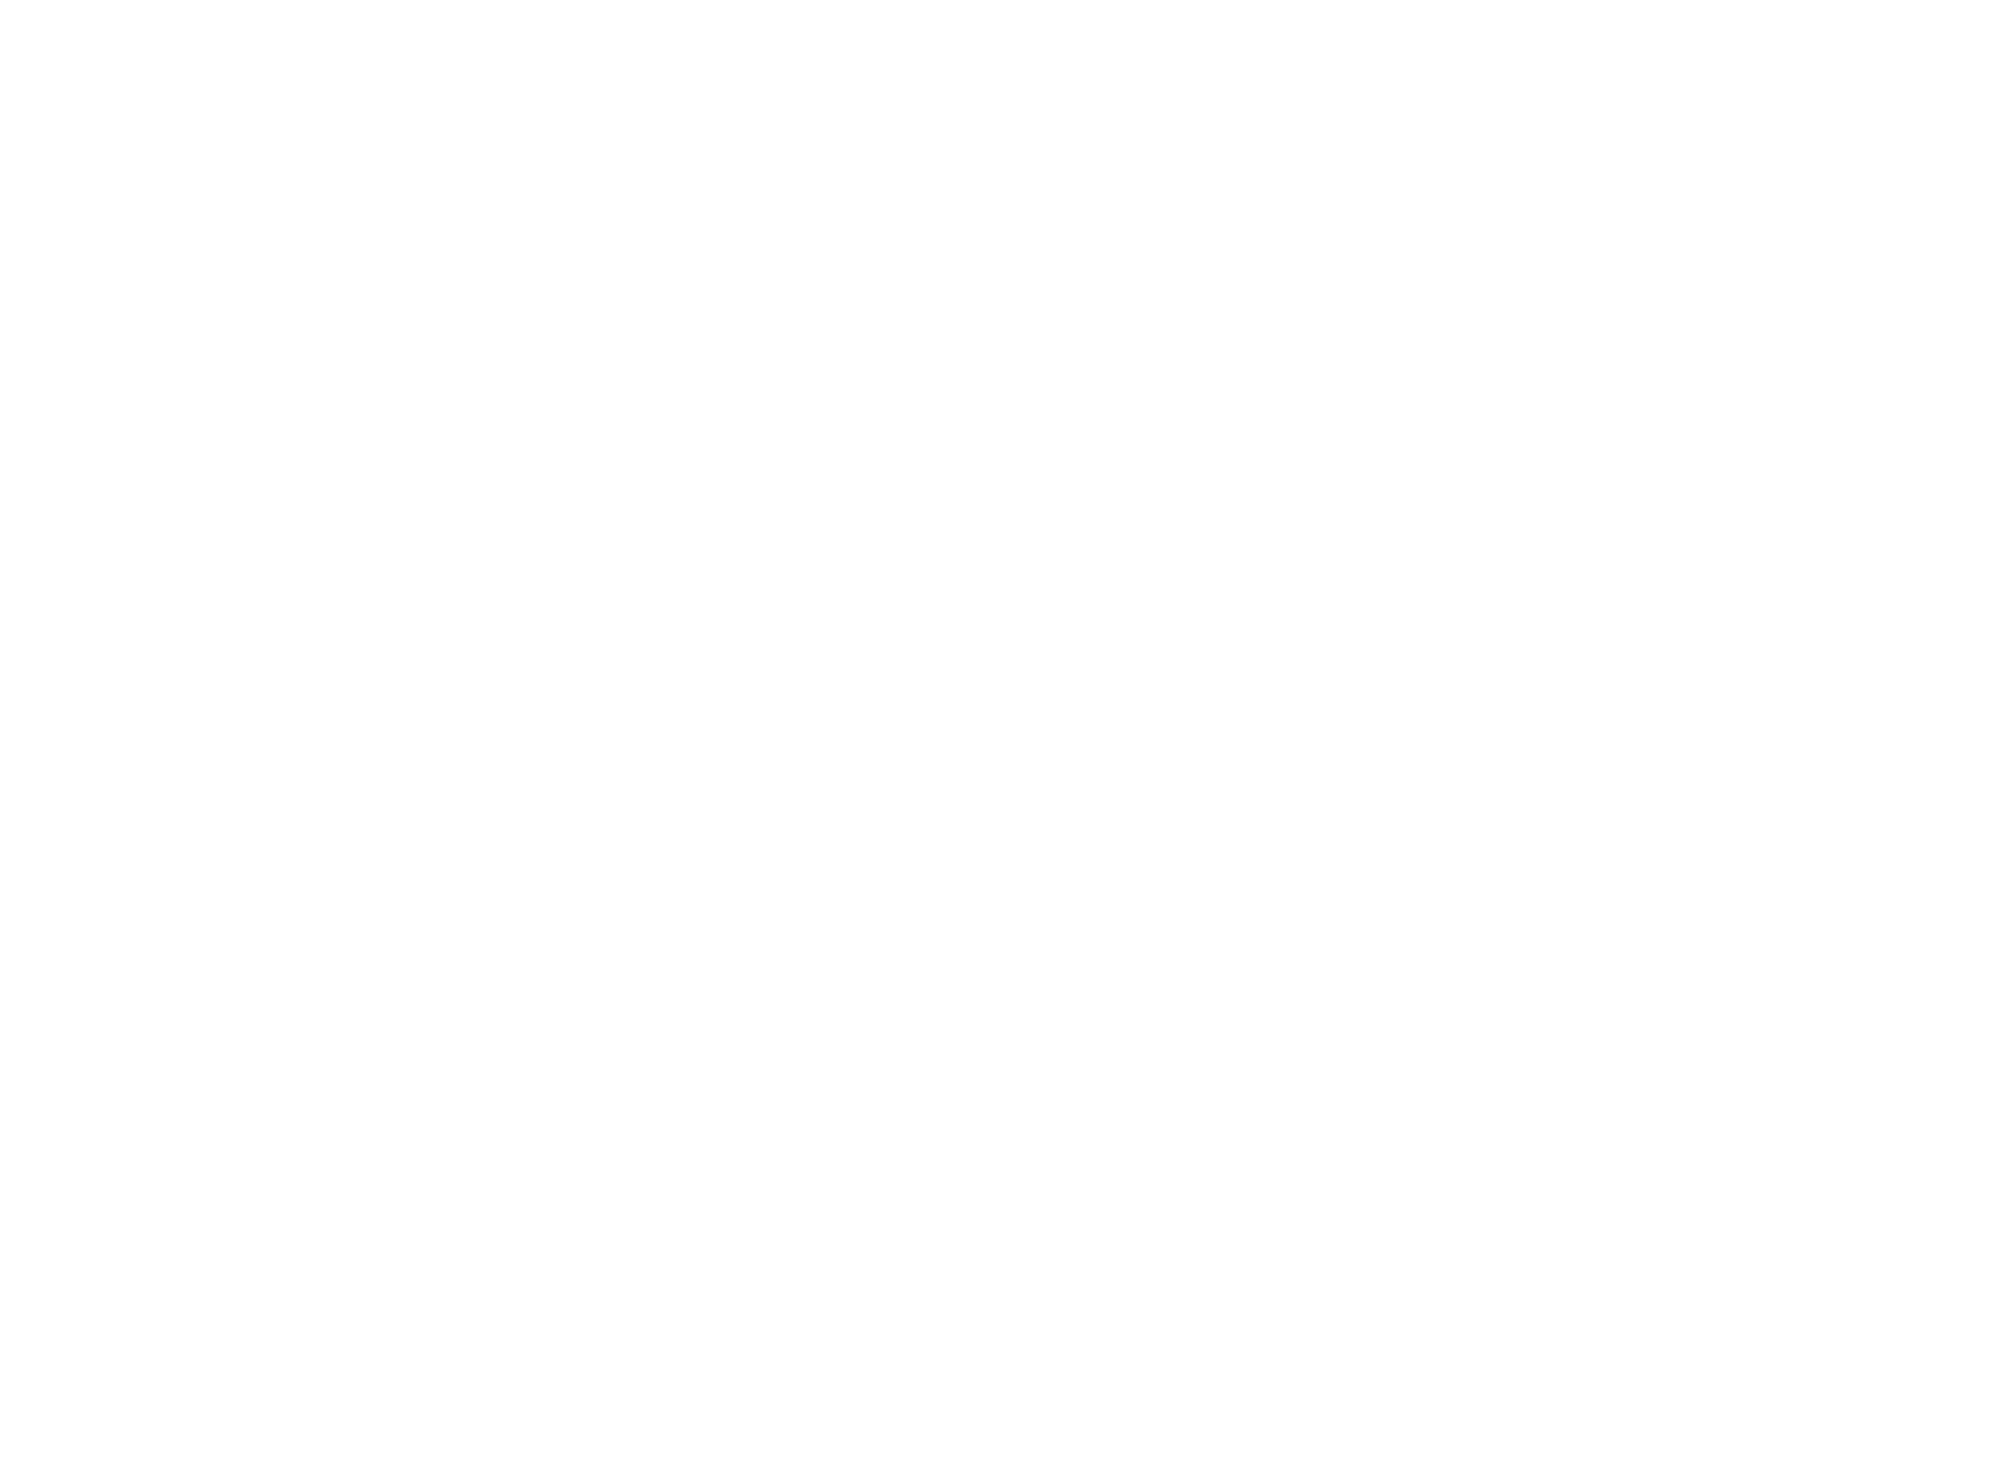

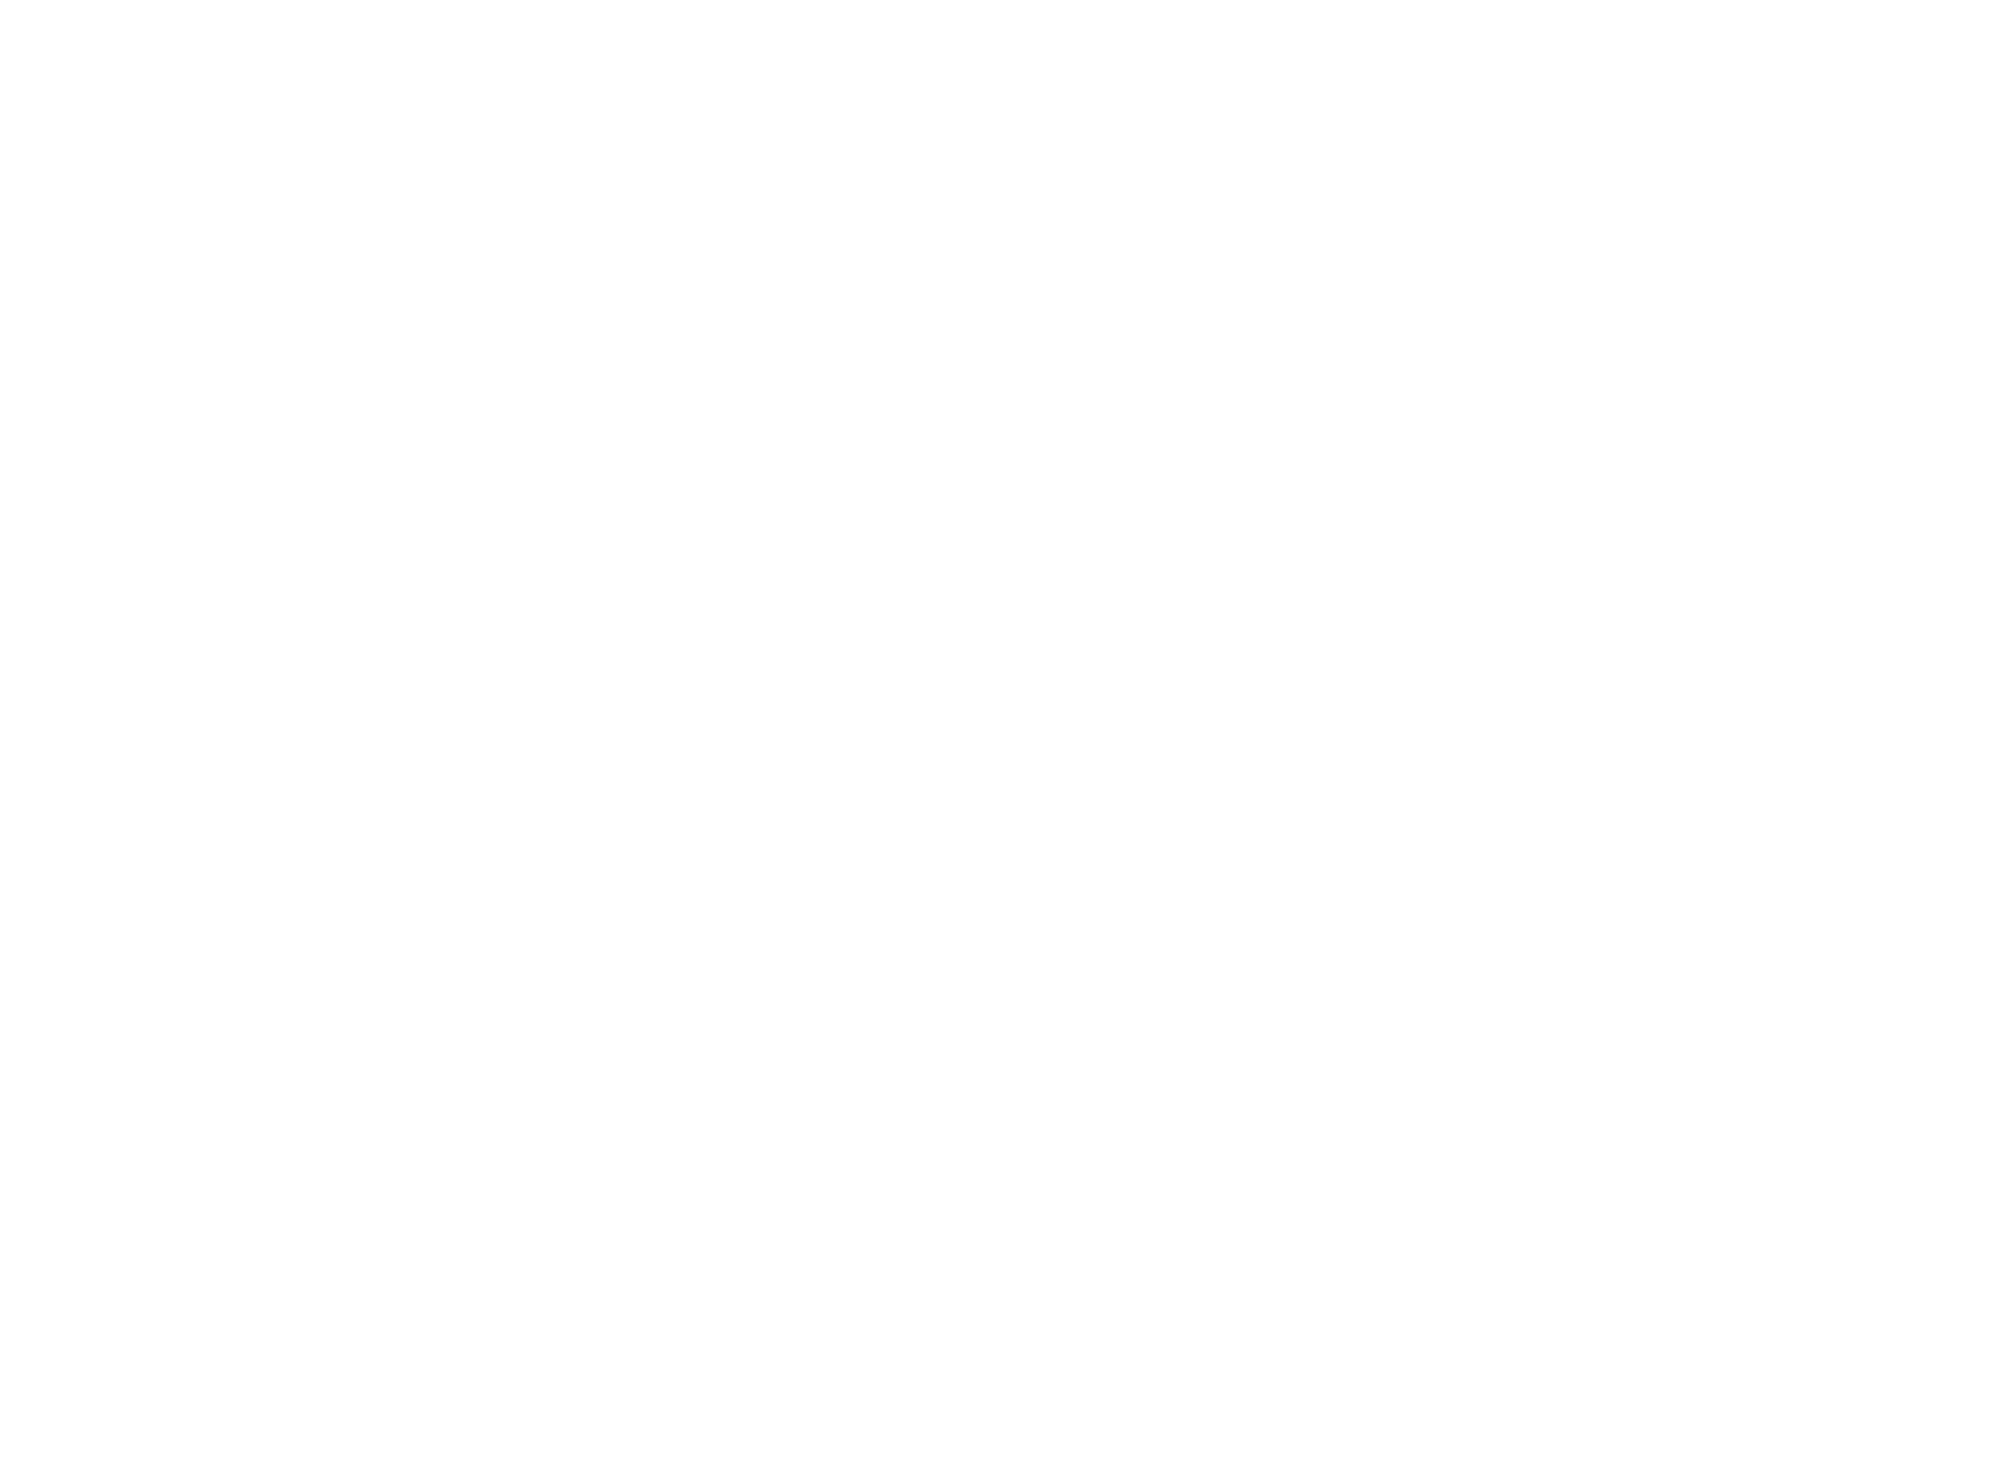

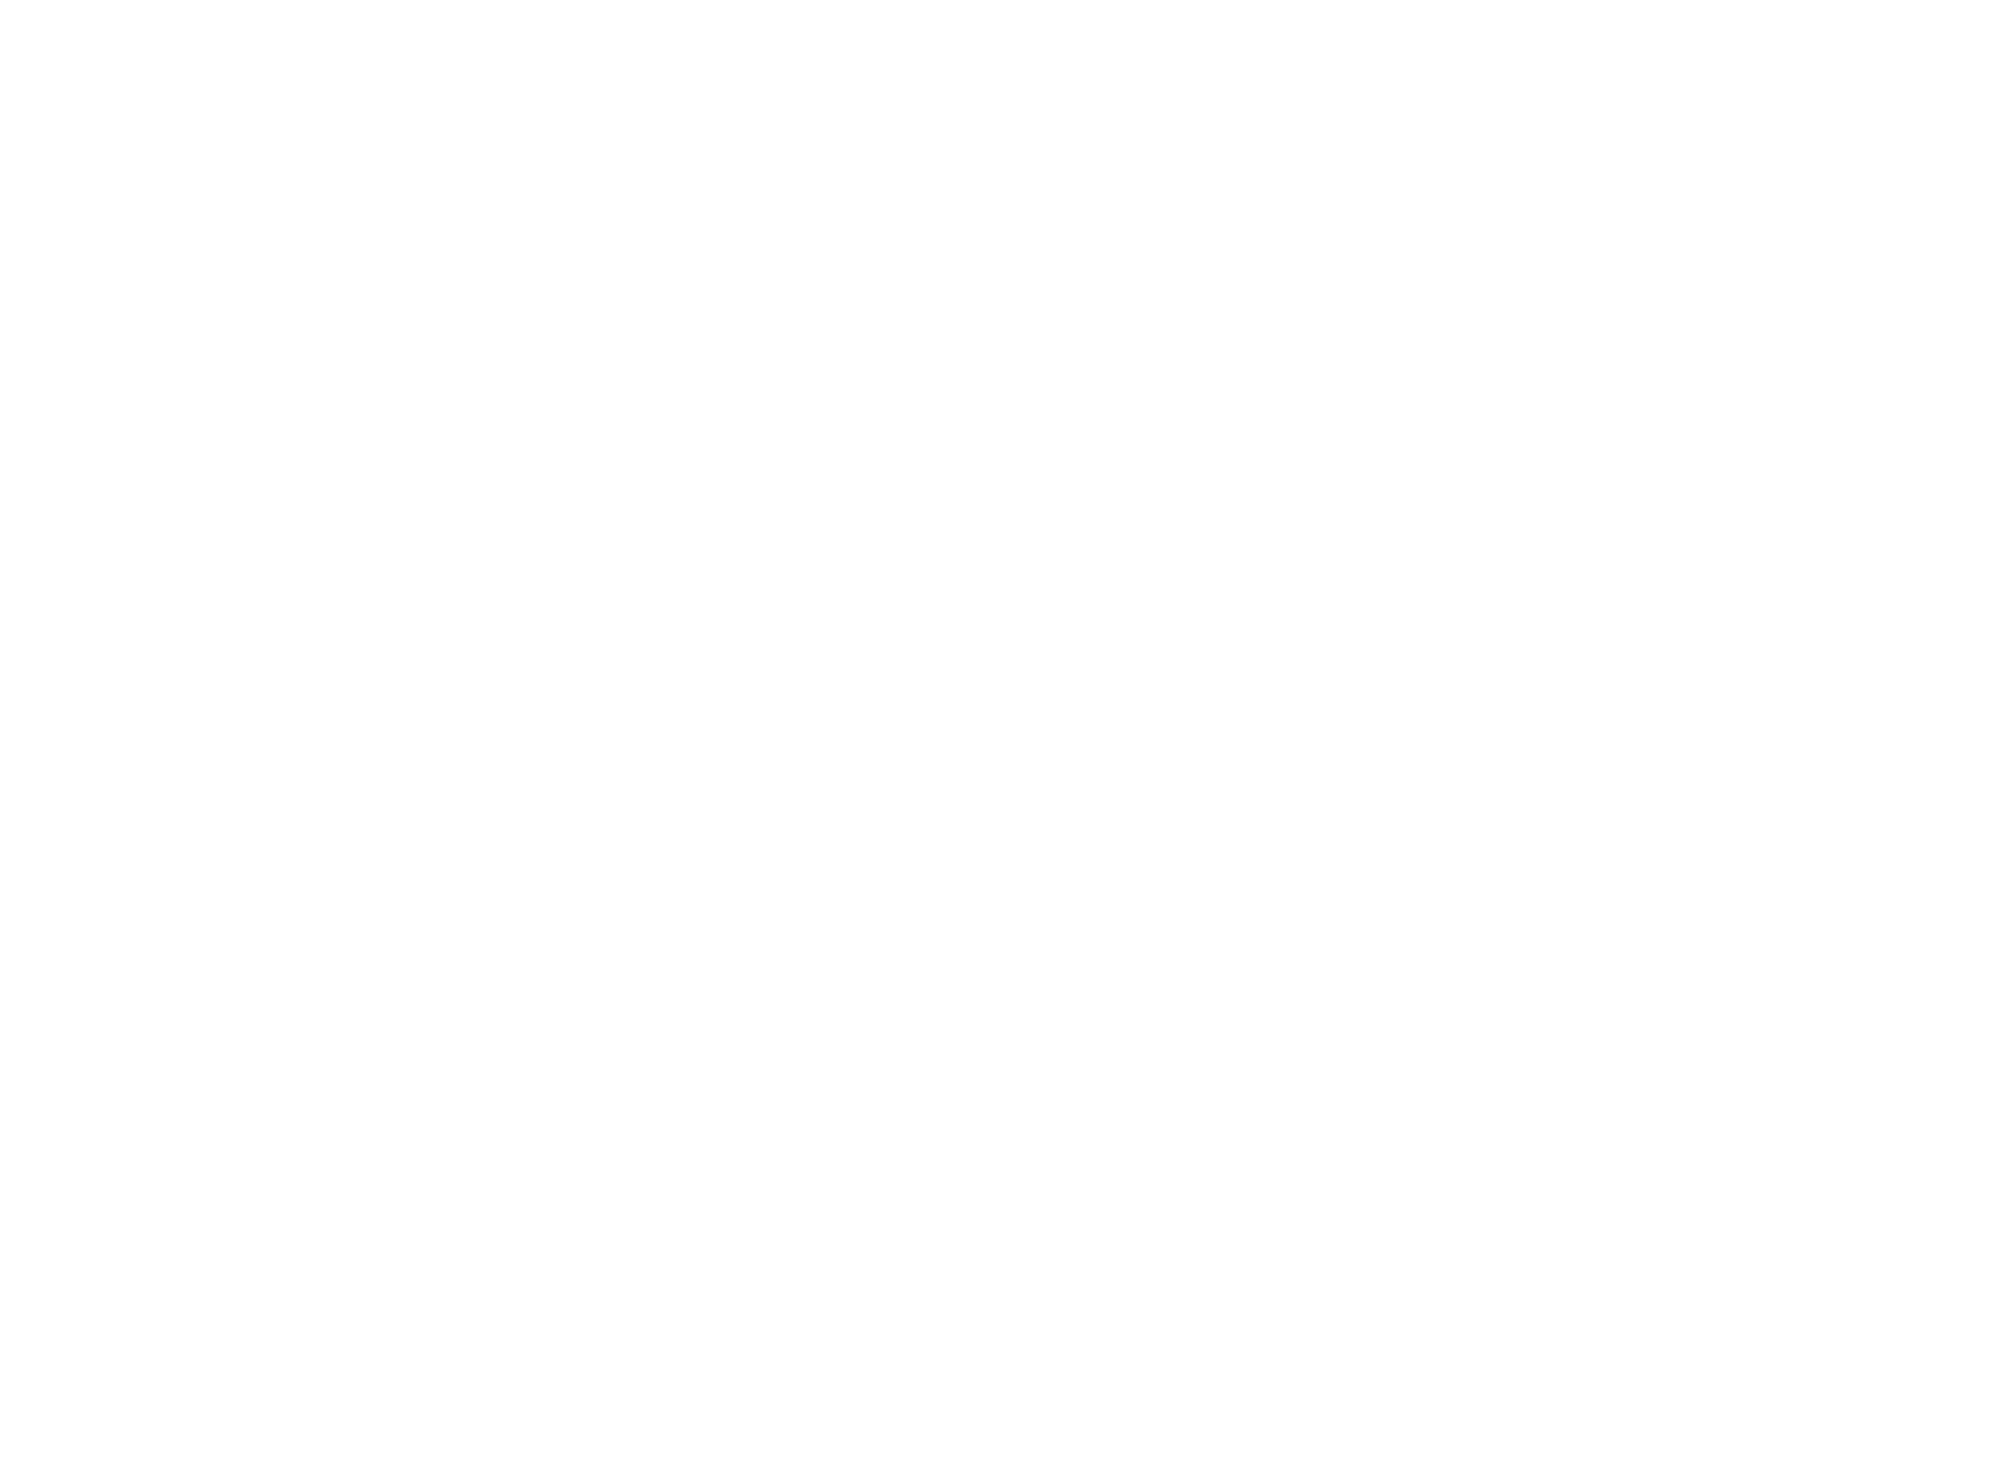

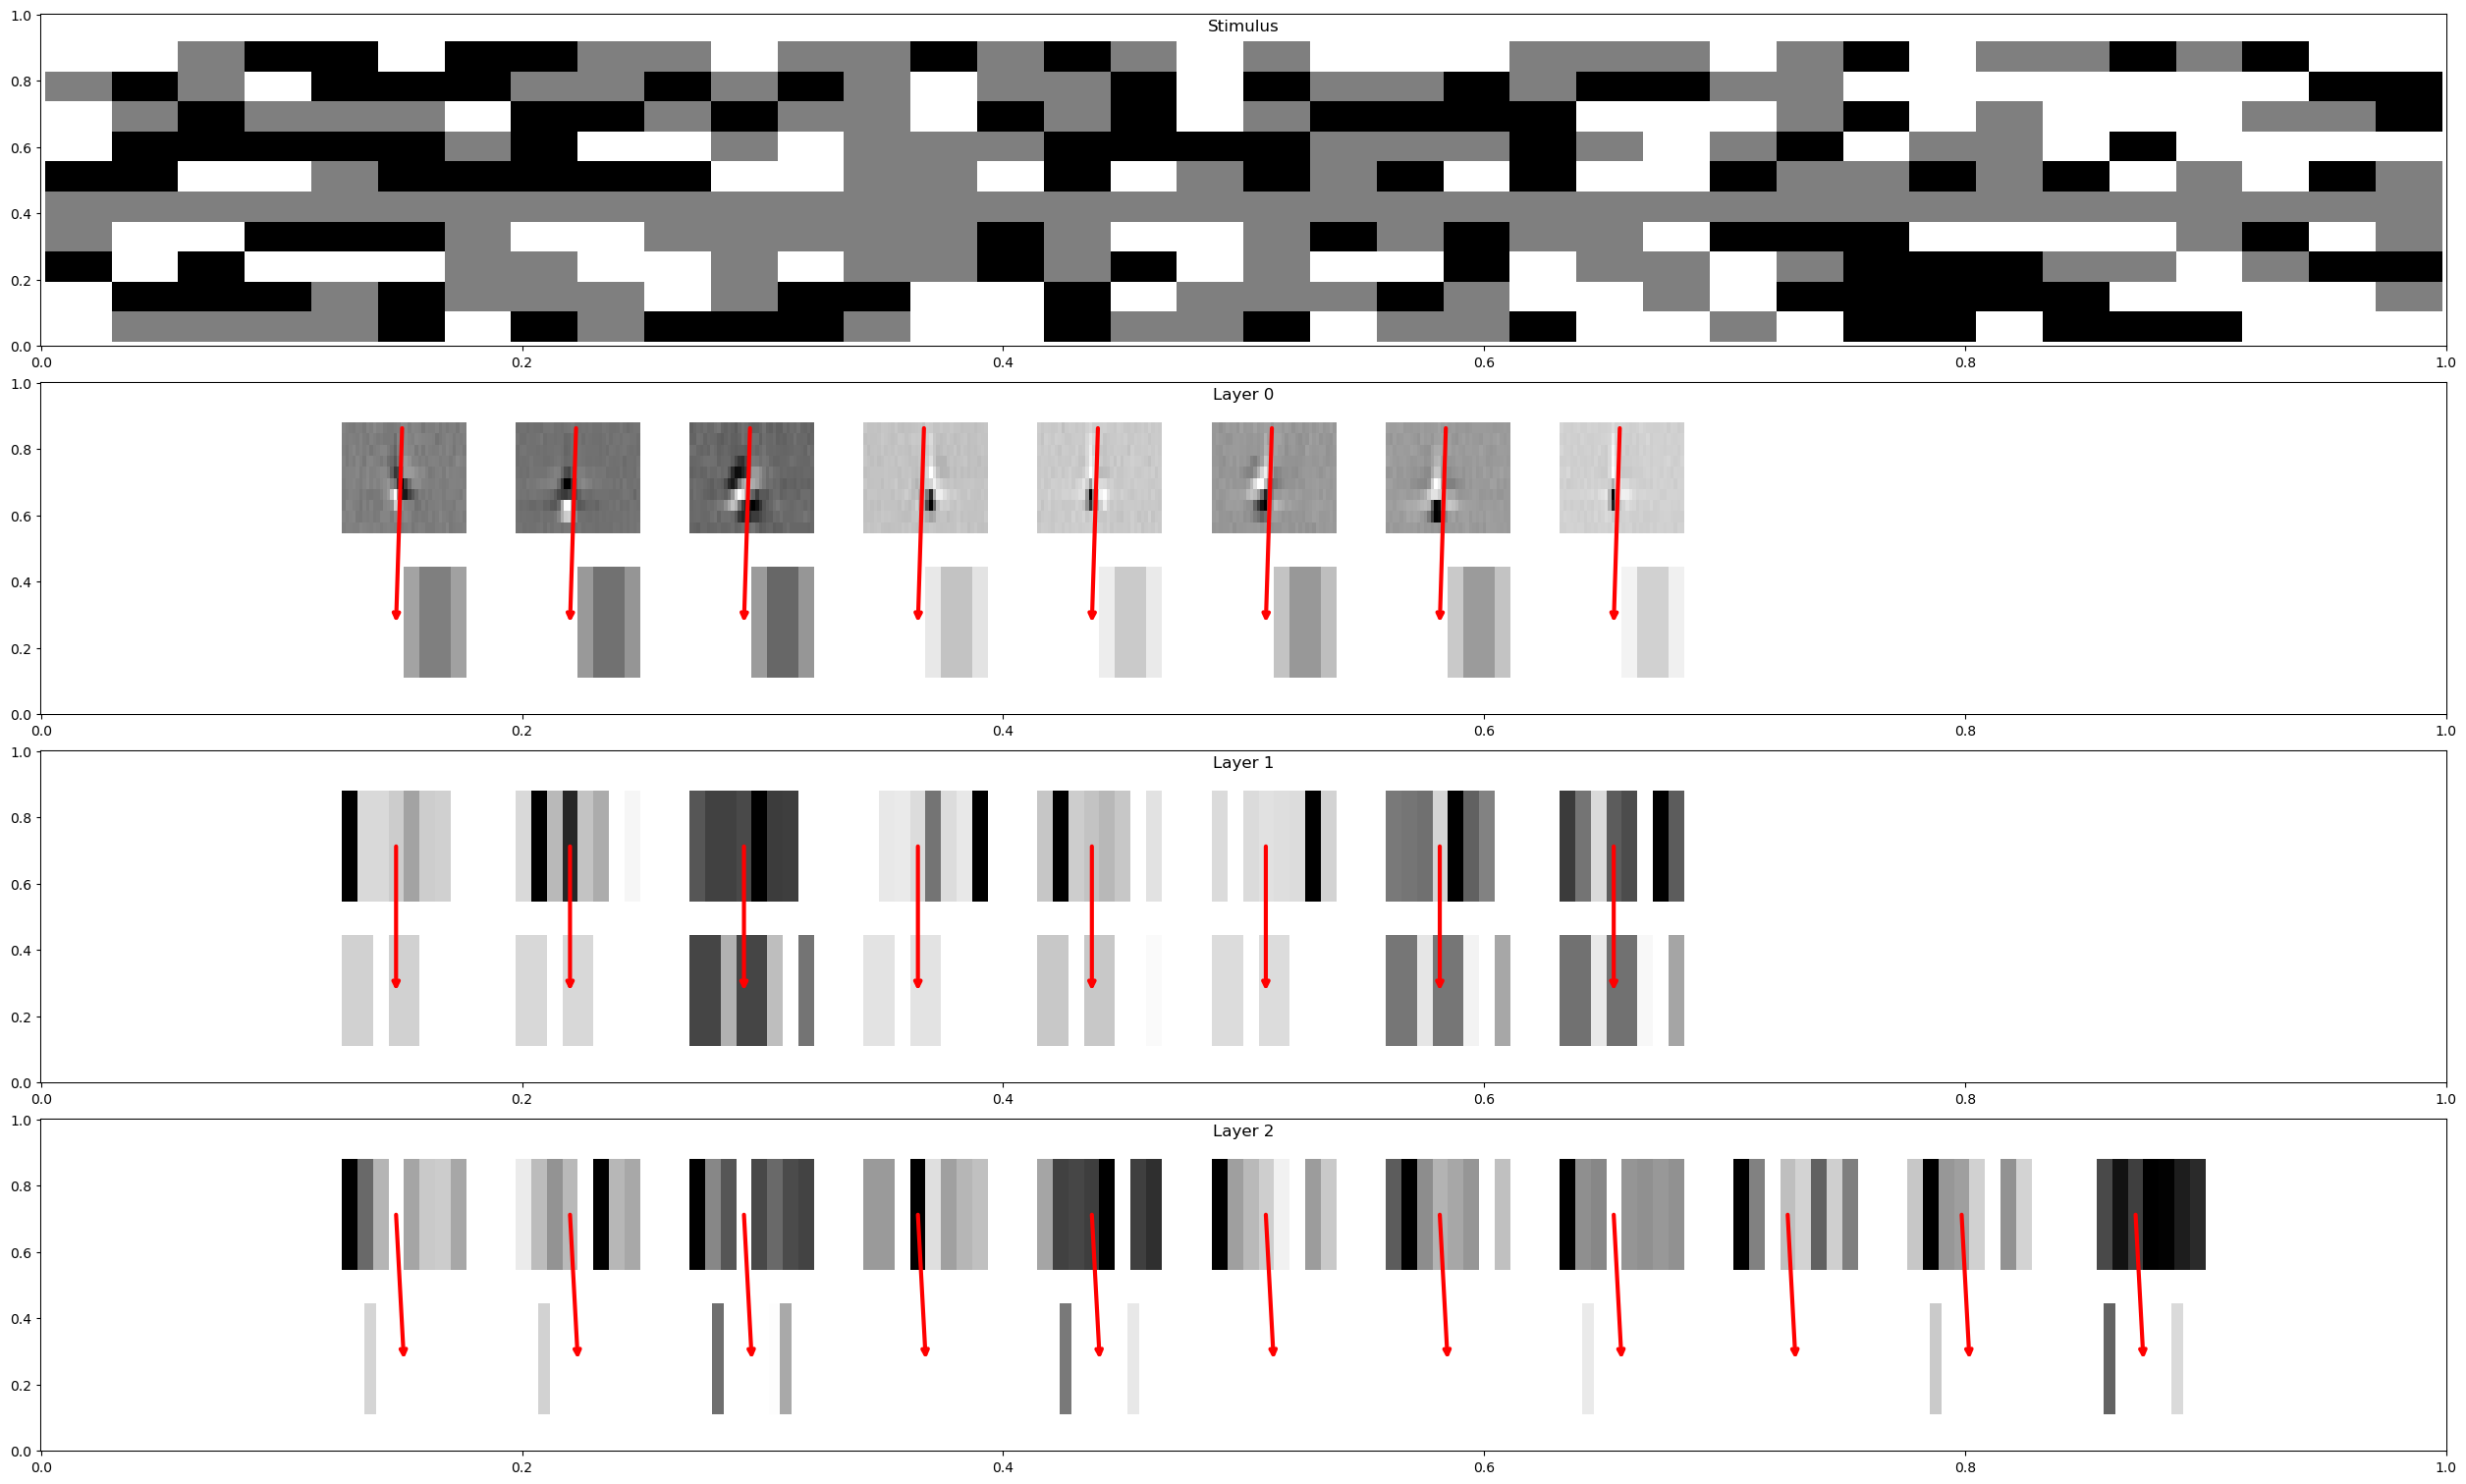

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import tqdm

img = [] # some array of images
frames = [] # for storing the generated images
bigfig = plt.figure()
for input in tqdm.tqdm(data.stim[:5]):
    fig = m.simulate_network(input, data.stim_dims,
                             nim2,
                             figsize=(25,15), max_cols=11)
    frames.append([fig])

ani = animation.ArtistAnimation(bigfig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('movie.mp4')